# Three Electrons Meet in a Bar

<center><img src="./images/qdef-banner.png" style="width: 500px"></center>

In [1]:
%load_ext line_profiler
%load_ext autoreload
# provide cell timings
%load_ext autotime
# %autoreload 2
import sympy as sp
import numpy as np
%config InlineBackend.figure_format='retina'
%config Completer.use_jedi = False
from qdef import *
from misc import *
from IPython.display import display, Math, Latex
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
import time
from itertools import product
new_labels = pickle.load(open('./Data/components_rosetta.pkl','rb'))
from itertools import permutations
from sympy import Eijk as εijk

Reloading /Volumes/GoogleDrive/My Drive/Zia Lab/Codebase/qdef/data/CPGs.pkl ...


In [2]:
def as_det_ket(qet):
    detket = sp.S(0)
    for k,v in qet.dict.items():
        symb = sp.Symbol((r'|%s|' % str(k)).replace('(','').replace(')','').replace(',',''))
        detket += symb * v
    return detket

## Cubic Group Γ1 Γ2 Γ3

In [100]:
def det_simplify(ket_parts):
    equivalent_parts = {}
    standard_order = {} # this holds the standard order to which all the other list members will be referred to
    for ket_part_key, ket_part_coeff in ket_parts.items():
        set_ket = frozenset(ket_part_key)
        if set_ket not in equivalent_parts:
            equivalent_parts[set_ket] = []
            standard_order[set_ket] = ket_part_key
        equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
    # once I've grouped them together into pices of equivalent parts
    # i then need to rearrange and properly sign the rearrangements
    det_simple = []
    for equivalent_key in equivalent_parts:
        base_order = standard_order[equivalent_key]
        total_coeff = 0
        equiv_parts = equivalent_parts[equivalent_key]
        for equiv_part in equiv_parts:
            ordering = [base_order.index(part) for part in equiv_part[0]]
            sign = εijk(*ordering)
            total_coeff += sign*equiv_part[1]
        final = (base_order, total_coeff)
        if total_coeff != 0:
            det_simple.append(final)
    return det_simple

def qet_divide(qet0, qet1):
    '''
    Given   two   qets,   assumed   to   be   superpositions  of
    determinantal states. Determine if they are collinear and if
    they are, provide their ratio.

    Parameters
    ----------
    qet0    (qdef.Qet) : a qet with determinantal keys.
    qet1    (qdef.Qet) : a qet with determinantal keys.

    Returns
    -------
    ratio (num): 0 if qets are not collinear, otherwise equal to
    qet0/qet1.


    '''
    if len(qet0.dict) != len(qet1.dict):
        return 0
    set0 = frozenset(map(frozenset,qet0.dict.keys()))
    set1 = frozenset(map(frozenset,qet1.dict.keys()))
    num_parts = len(qet0.dict)
    # a necessary condition for them to be possibly collinear
    # is that they should have have the same sets of quantum
    # numbers.
    if set0 != set1:
        return 0
    else:
        ratios = []
        # iterate over the quantum nums of the first qet
        for qet_key_0, qet_val_0 in qet0.dict.items():
            set0 = set(qet_key_0)
            # and determine the ratio that it has
            # to all of the parts of the other qet
            # allowing for reaarangmenets valid
            # under determinantal state rules
            for qet_key_1, qet_val_1 in qet1.dict.items():
                set1 = set(qet_key_1)
                if set0 == set1:
                    ordering = [qet_key_0.index(qk) for qk in qet_key_1]
                    sign = εijk(*ordering)
                    ratios.append(sign * qet_val_0/qet_val_1)
                    continue
    if ratios == []:
        return 0
    else:
        # if all of the ratios are equal
        # then the ratio of the two qets
        # is well defined
        if len(set(ratios)) == 1 and len(ratios) == num_parts:
            return ratios[0]
        else:
            return 0

# final_qets = []
# corresponding_waves = []
# for total_ket_key_0, simple_ket_0 in simplified_kets.items():
#     ratios = []
#     for simple_ket_1 in final_qets:
#         divvy = qet_divide(simple_ket_0, simple_ket_1)
#         ratios.append(divvy==0)
#     ratios = sum(ratios)
#     if ratios == len(final_qets):
#         final_qets.append(simple_ket_0)
#         corresponding_waves.append(total_ket_key_0)
# final_qets = list(zip(corresponding_waves, final_qets))

In [121]:
def three_electron_waves(group_label, Γ1, Γ2, Γ3, disambiguate = False):
    '''
    Given  a  label for a crystallographic point group and three
    labels   for   corresponding   irreducible  representations.
    Produce  all the three electron wavefunctions  assuming that
    all the electrons are equivalent.

    Parameters
    ----------
    group_label     (str):
    Γ1        (sp.Symbol): label for an irrep of G
    Γ2        (sp.Symbol): label for an irrep of G
    Γ3        (sp.Symbol): label for an irrep of G
    disambiguate   (bool): if verbose output is returned

    Returns
    -------
    if disambiguate == False:
        final_qets      (dict): 
            keys -> (Γ_total, γ_total, 2*S_total+1, M_total, S_12, Γ_12)
            values -> qdef.Qet with determinantal states
    if disambiguate == True then also final_qets_groups is returned
        final_qets_groups (dict):
            keys -> (Γ_total, γ_total, 2*S_total+1, M_total, S_12, Γ_12)
            values -> dict() with keys 'paths' and 'qet'
                with 'paths' a list with all alternate intermediate two-
                electron states that lead to the same final qet.
    
    Where  S_12  is  the  spin  of the intermediate two-electron
    wavefunction and Γ_12 its corresponding irrep.
    '''
    # get the group
    group = CPGs.get_group_by_label(group_label)
    # get the CGs
    group_CGs = group.CG_coefficients
    # enforce the better notation for components
    flat_labels = dict(sum([list(l.items()) for l in list(new_labels[group_label].values())],[]))
    group_CGs = {(flat_labels[k[0]], flat_labels[k[1]], flat_labels[k[2]]):v for k,v in group_CGs.items()}

    irreps = group.irrep_labels
    s_half = sp.S(1)/2
    ms = mrange(s_half)

    component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
    comps_1, comps_2, comps_3 = [component_labels[ir] for ir in [Γ1, Γ2, Γ3]]
    s1, s2, s3 = s_half, s_half, s_half

    Γ12s = group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
    S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
    total_kets = {}

    counter = 0
    for γ1, γ2, γ3, m1, m2, m3, Γ12, S12 in product(comps_1, comps_2, comps_3, ms, ms, ms, Γ12s, S12s):
        Γs = group.product_table.odict[(Γ12, Γ3)]
        Ss = lrange(S12, s3)
        comps_12 = component_labels[Γ12]
        M12s = mrange(S12)
        for Γ in Γs:
            comps = component_labels[Γ]
            for S in Ss:
                Ms = mrange(S)
                for γ, M12, M, γ12 in product(comps, M12s, Ms, comps_12):
                    total_ket_key = (Γ, γ, 2*S+1, M, S12, Γ12)
                    # summing s1 and s2 to yield S12
                    sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
                    # summing S12 and s3 to give the final S, M
                    sCG2 = clebschG.eva(S12, s3, S, M12, m3, M)
                    # coupling a γ1, γ2 to get a γ12
                    gCG1 = group_CGs.setdefault((γ1, γ2, γ12), 0)
                    # coupling a γ12, γ3 to get a final γ
                    gCG2 = group_CGs.setdefault((γ12, γ3, γ), 0)
                    coeff = sCG1 * sCG2 * gCG1 * gCG2
                    if coeff == 0:
                        continue
                    # collect in the dictionary all the parts that correspond to the sums
                    if total_ket_key not in total_kets:
                        total_kets[total_ket_key] = {}
                    if m1 < 0:
                        γ1f = bar_symbol(γ1)
                    else:
                        γ1f = γ1
                    if m2 < 0:
                        γ2f = bar_symbol(γ2)
                    else:
                        γ2f = γ2
                    if m3 < 0:
                        γ3f = bar_symbol(γ3)
                    else:
                        γ3f= γ3
                    total_ket_part_key = (γ1f, γ2f, γ3f)
                    if total_ket_part_key not in total_kets[total_ket_key]:
                        total_kets[total_ket_key][total_ket_part_key] = 0
                    total_kets[total_ket_key][total_ket_part_key] += coeff
                    counter += 1

    # The resulting qets may have redundant parts in that 
    # a rearrangment of the quantum symbols may be equal
    # to another part.
    # This makes it necessary to do some rearrangment
    # juggling, and permutations signing.

    simplified_kets = {}
    for total_ket_key, ket_parts in total_kets.items():
        det_simplified = det_simplify(ket_parts)
        if len(det_simplified) != 0:
            simplified_kets[total_ket_key] = Qet(dict(det_simplified))
            the_normalizer = 1/simplified_kets[total_ket_key].norm()
            simplified_kets[total_ket_key] = the_normalizer*simplified_kets[total_ket_key]

    final_qets = []
    corresponding_waves = []
    for total_ket_key_0, simple_ket_0 in simplified_kets.items():
        ratios = []
        for simple_ket_1 in final_qets:
            divvy = qet_divide(simple_ket_0, simple_ket_1)
            ratios.append(divvy==0)
        ratios = sum(ratios)
        if ratios == len(final_qets):
            final_qets.append(simple_ket_0)
            corresponding_waves.append(total_ket_key_0)
    final_qets = list(zip(corresponding_waves, final_qets))

    # in addition to removing the redundant ones
    # I would also like to keep al the total_ket_keys that correspond to each
    # group of redundant qets
    if disambiguate:
        final_qets_groups = {}
        for main_key, sqet in final_qets:
            final_qets_groups[main_key] = {'paths':[],'qet':sqet}
            for total_ket_key_0, simple_ket_0 in simplified_kets.items():
                if qet_divide(sqet, simple_ket_0) != 0:
                    final_qets_groups[main_key]['paths'].append(total_ket_key_0)
        return final_qets, final_qets_groups
    else:
        return final_qets
    

In [130]:
three_irreps_combos = list(combinations_with_replacement(irreps,3))

In [140]:
group_label = 'O'
all_three_electron_funs = {}
print(len(three_irreps_combos))
for idx, irrep_combo in enumerate(three_irreps_combos):
    print(idx,end='|')
    all_three_electron_funs[irrep_combo] = three_electron_waves(group_label,*irrep_combo)

35
0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|

In [145]:
tally = 0
for irrep_combo in all_three_electron_funs:
    print(irrep_combo, len(all_three_electron_funs[irrep_combo]))
    tally += len(all_three_electron_funs[irrep_combo])
print("Total of %s three electron wavefunctions." % tally)

(A_1, A_1, A_1) 0
(A_1, A_1, A_2) 2
(A_1, A_1, E) 4
(A_1, A_1, T_1) 6
(A_1, A_1, T_2) 6
(A_1, A_2, A_2) 2
(A_1, A_2, E) 16
(A_1, A_2, T_1) 24
(A_1, A_2, T_2) 24
(A_1, E, E) 12
(A_1, E, T_1) 48
(A_1, E, T_2) 48
(A_1, T_1, T_1) 30
(A_1, T_1, T_2) 72
(A_1, T_2, T_2) 30
(A_2, A_2, A_2) 0
(A_2, A_2, E) 4
(A_2, A_2, T_1) 6
(A_2, A_2, T_2) 6
(A_2, E, E) 12
(A_2, E, T_1) 48
(A_2, E, T_2) 48
(A_2, T_1, T_1) 30
(A_2, T_1, T_2) 72
(A_2, T_2, T_2) 30
(E, E, E) 4
(E, E, T_1) 36
(E, E, T_2) 36
(E, T_1, T_1) 72
(E, T_1, T_2) 144
(E, T_2, T_2) 72
(T_1, T_1, T_1) 20
(T_1, T_1, T_2) 90
(T_1, T_2, T_2) 136
(T_2, T_2, T_2) 20
Total of 1210 three electron wavefunctions.


In [109]:
# for k,v in final_qets_groups.items():
#     print(k,'||', len(v['paths']), '||', (v['paths']))
#     display(as_det_ket(v['qet']))

In [124]:
final_qets = three_electron_waves('O',sp.Symbol('T_2'), sp.Symbol('T_2'), sp.Symbol('T_2'), disambiguate=True)

20

In [126]:
len(final_qets[1])

20

## Cubic Group T2 T2 E

In [31]:
def det_simplify(ket_parts):
    equivalent_parts = {}
    standard_order = {} # this holds the standard order to which all the other list members will be referred to
    for ket_part_key, ket_part_coeff in ket_parts.items():
        set_ket = frozenset(ket_part_key)
        if set_ket not in equivalent_parts:
            equivalent_parts[set_ket] = []
            standard_order[set_ket] = ket_part_key
        equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
    # once I've grouped them together into pices of equivalent parts
    # i then need to rearrange and properly sign the rearrangements
    det_simple = []
    for equivalent_key in equivalent_parts:
        base_order = standard_order[equivalent_key]
        total_coeff = 0
        equiv_parts = equivalent_parts[equivalent_key]
        for equiv_part in equiv_parts:
            ordering = [base_order.index(part) for part in equiv_part[0]]
            sign = εijk(*ordering)
            total_coeff += sign*equiv_part[1]
        final = (base_order, total_coeff)
        if total_coeff != 0:
            det_simple.append(final)
    return det_simple

def qet_divide(qet0, qet1):
    '''
    Given   two   qets,   assumed   to   be   superpositions  of
    determinantal states. Determine if they are collinear and if
    they are, provide their ratio.

    Parameters
    ----------
    qet0    (qdef.Qet) : a qet with determinantal keys.
    qet1    (qdef.Qet) : a qet with determinantal keys.

    Returns
    -------
    ratio (num): 0 if qets are not collinear, otherwise equal to
    qet0/qet1.


    '''
    if len(qet0.dict) != len(qet1.dict):
        return 0
    set0 = frozenset(map(frozenset,qet0.dict.keys()))
    set1 = frozenset(map(frozenset,qet1.dict.keys()))
    num_parts = len(qet0.dict)
    # a necessary condition for them to be possibly collinear
    # is that they should have have the same sets of quantum
    # numbers.
    if set0 != set1:
        return 0
    else:
        ratios = []
        # iterate over the quantum nums of the first qet
        for qet_key_0, qet_val_0 in qet0.dict.items():
            set0 = set(qet_key_0)
            # and determine the ratio that it has
            # to all of the parts of the other qet
            # allowing for reaarangmenets valid
            # under determinantal state rules
            for qet_key_1, qet_val_1 in qet1.dict.items():
                set1 = set(qet_key_1)
                if set0 == set1:
                    ordering = [qet_key_0.index(qk) for qk in qet_key_1]
                    sign = εijk(*ordering)
                    ratios.append(sign * qet_val_0/qet_val_1)
                    continue
    if ratios == []:
        return 0
    else:
        # if all of the ratios are equal
        # then the ratio of the two qets
        # is well defined
        if len(set(ratios)) == 1 and len(ratios) == num_parts:
            return ratios[0]
        else:
            return 0

final_qets = []
corresponding_waves = []
for total_ket_key_0, simple_ket_0 in simplified_kets.items():
    ratios = []
    for simple_ket_1 in final_qets:
        divvy = qet_divide(simple_ket_0, simple_ket_1)
        ratios.append(divvy==0)
    ratios = sum(ratios)
    if ratios == len(final_qets):
        final_qets.append(simple_ket_0)
        corresponding_waves.append(total_ket_key_0)
final_qets = list(zip(corresponding_waves, final_qets))

In [80]:
for irrep in irreps:
    print(irrep,group.product_table.odict[(irrep, sp.Symbol('E'))])

A_1 [E]
A_2 [E]
E [A_1, A_2, E]
T_1 [T_1, T_2]
T_2 [T_1, T_2]


In [ ]:
# group_label = 'O'
# # get the group
# group = CPGs.get_group_by_label(group_label)
# # get the CGs
# group_CGs = group.CG_coefficients
# # enforce the better notation for components
# flat_labels = dict(sum([list(l.items()) for l in list(new_labels[group_label].values())],[]))
# group_CGs = {(flat_labels[k[0]], flat_labels[k[1]], flat_labels[k[2]]):v for k,v in group_CGs.items()}

# coupler = {}
# irreps = group.irrep_labels
# ms = [-sp.S(1)/2,sp.S(1)/2] # for a spin 1/2
# s_half = sp.S(1)/2

# component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
# Γ1, Γ2, Γ3 = sp.Symbol('T_2'), sp.Symbol('T_2'), sp.Symbol('E')
# comps_1, comps_2, comps_3 = [component_labels[ir] for ir in [Γ1, Γ2, Γ3]]
# s1, s2, s3 = s_half, s_half, s_half

# Γ12s = group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
# S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
# total_kets = {}

# counter = 0
# for Γ, γ1, γ2, γ3, m1, m2, m3, Γ12, S12 in product(irreps, comps_1, comps_2, comps_3, ms, ms, ms, Γ12s, S12s):
#     # comps = component_labels[Γ]
#     comps = component_labels[group.product_table.odict[(Γ12, Γ3)]]
#     Ss = lrange(S12, s3)
#     comps_12 = component_labels[Γ12]
#     M12s = mrange(S12)
#     for S in Ss:
#         Ms = mrange(S)
#         for γ, M12, M, γ12 in product(comps, M12s, Ms, comps_12):
#             total_ket_key = (Γ, γ, 2*S+1, M, S12, Γ12)
#             # summing s1 and s2 to yield S12
#             sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
#             # summing S12 and s3 to give the final S, M
#             sCG2 = clebschG.eva(S12, s3, S, M12, m3, M)
#             # coupling a γ1, γ2 to get a γ12
#             gCG1 = group_CGs.setdefault((γ1, γ2, γ12), 0)
#             # coupling a γ12, γ3 to get a final γ
#             gCG2 = group_CGs.setdefault((γ12, γ3, γ), 0)
#             coeff = sCG1 * sCG2 * gCG1 * gCG2
#             if coeff == 0:
#                 continue
#             # collect in the dictionary all the parts that correspond to the sums
#             if total_ket_key not in total_kets:
#                 total_kets[total_ket_key] = {}
#             if m1 < 0:
#                 γ1f = bar_symbol(γ1)
#             else:
#                 γ1f = γ1
#             if m2 < 0:
#                 γ2f = bar_symbol(γ2)
#             else:
#                 γ2f = γ2
#             if m3 < 0:
#                 γ3f = bar_symbol(γ3)
#             else:
#                 γ3f= γ3
#             total_ket_part_key = (γ1f, γ2f, γ3f)
#             if total_ket_part_key not in total_kets[total_ket_key]:
#                 total_kets[total_ket_key][total_ket_part_key] = 0
#             total_kets[total_ket_key][total_ket_part_key] += coeff
#             counter += 1

# # The resulting qets may have redundant parts in that 
# # a rearrangment of the quantum symbols may be equal
# # to another part.
# # This makes it necessary to do some rearrangment
# # juggling

# simplified_kets = {}
# for total_ket_key, ket_parts in total_kets.items():
#     det_simplified = det_simplify(ket_parts)
#     if len(det_simplified) != 0:
#         simplified_kets[total_ket_key] = Qet(dict(det_simplified))
#         the_normalizer = 1/simplified_kets[total_ket_key].norm()
#         simplified_kets[total_ket_key] = the_normalizer*simplified_kets[total_ket_key]

# final_qets = []
# corresponding_waves = []
# for total_ket_key_0, simple_ket_0 in simplified_kets.items():
#     ratios = []
#     for simple_ket_1 in final_qets:
#         divvy = qet_divide(simple_ket_0, simple_ket_1)
#         ratios.append(divvy==0)
#     ratios = sum(ratios)
#     if ratios == len(final_qets):
#         final_qets.append(simple_ket_0)
#         corresponding_waves.append(total_ket_key_0)
# final_qets = list(zip(corresponding_waves, final_qets))

# # in addition to removing the redundant ones
# # I would also like to keep al the total_ket_keys that correspond to each
# # group of redundant qets
# final_qets_groups = {}
# for main_key, sqet in final_qets:
#     final_qets_groups[main_key] = {'paths':[],'qet':sqet}
#     for total_ket_key_0, simple_ket_0 in simplified_kets.items():
#         if qet_divide(sqet, simple_ket_0) != 0:
#             final_qets_groups[main_key]['paths'].append(total_ket_key_0)
# for k,v in final_qets_groups.items():
#     print(k,'||', len(v['paths']), '||', (v['paths']))
#     display(as_det_ket(v['qet']))

In [ ]:
group_label = 'O'
# get the group
group = CPGs.get_group_by_label(group_label)
# get the CGs
group_CGs = group.CG_coefficients
# enforce the better notation for components
flat_labels = dict(sum([list(l.items()) for l in list(new_labels[group_label].values())],[]))
group_CGs = {(flat_labels[k[0]], flat_labels[k[1]], flat_labels[k[2]]):v for k,v in group_CGs.items()}

coupler = {}
irreps = group.irrep_labels
ms = [-sp.S(1)/2,sp.S(1)/2] # for a spin 1/2
s_half = sp.S(1)/2

component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
Γ1, Γ2, Γ3 = sp.Symbol('T_2'), sp.Symbol('T_2'), sp.Symbol('E')
comps_1, comps_2, comps_3 = [component_labels[ir] for ir in [Γ1, Γ2, Γ3]]
s1, s2, s3 = s_half, s_half, s_half

Γ12s = group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
total_kets = {}

counter = 0
for γ1, γ2, γ3, m1, m2, m3, Γ12, S12 in product(comps_1, comps_2, comps_3, ms, ms, ms, Γ12s, S12s):
    Γs = group.product_table.odict[(Γ12, Γ3)]
    for Γ in Γs:
        comps = component_labels[Γ]
        Ss = lrange(S12, s3)
        comps_12 = component_labels[Γ12]
        M12s = mrange(S12)
        for S in Ss:
            Ms = mrange(S)
            for γ, M12, M, γ12 in product(comps, M12s, Ms, comps_12):
                total_ket_key = (Γ, γ, 2*S+1, M, S12, Γ12)
                # summing s1 and s2 to yield S12
                sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
                # summing S12 and s3 to give the final S, M
                sCG2 = clebschG.eva(S12, s3, S, M12, m3, M)
                # coupling a γ1, γ2 to get a γ12
                gCG1 = group_CGs.setdefault((γ1, γ2, γ12), 0)
                # coupling a γ12, γ3 to get a final γ
                gCG2 = group_CGs.setdefault((γ12, γ3, γ), 0)
                coeff = sCG1 * sCG2 * gCG1 * gCG2
                if coeff == 0:
                    continue
                # collect in the dictionary all the parts that correspond to the sums
                if total_ket_key not in total_kets:
                    total_kets[total_ket_key] = {}
                if m1 < 0:
                    γ1f = bar_symbol(γ1)
                else:
                    γ1f = γ1
                if m2 < 0:
                    γ2f = bar_symbol(γ2)
                else:
                    γ2f = γ2
                if m3 < 0:
                    γ3f = bar_symbol(γ3)
                else:
                    γ3f= γ3
                total_ket_part_key = (γ1f, γ2f, γ3f)
                if total_ket_part_key not in total_kets[total_ket_key]:
                    total_kets[total_ket_key][total_ket_part_key] = 0
                total_kets[total_ket_key][total_ket_part_key] += coeff
                counter += 1

# The resulting qets may have redundant parts in that 
# a rearrangment of the quantum symbols may be equal
# to another part.
# This makes it necessary to do some rearrangment
# juggling

simplified_kets = {}
for total_ket_key, ket_parts in total_kets.items():
    det_simplified = det_simplify(ket_parts)
    if len(det_simplified) != 0:
        simplified_kets[total_ket_key] = Qet(dict(det_simplified))
        the_normalizer = 1/simplified_kets[total_ket_key].norm()
        simplified_kets[total_ket_key] = the_normalizer*simplified_kets[total_ket_key]

final_qets = []
corresponding_waves = []
for total_ket_key_0, simple_ket_0 in simplified_kets.items():
    ratios = []
    for simple_ket_1 in final_qets:
        divvy = qet_divide(simple_ket_0, simple_ket_1)
        ratios.append(divvy==0)
    ratios = sum(ratios)
    if ratios == len(final_qets):
        final_qets.append(simple_ket_0)
        corresponding_waves.append(total_ket_key_0)
final_qets = list(zip(corresponding_waves, final_qets))

# in addition to removing the redundant ones
# I would also like to keep al the total_ket_keys that correspond to each
# group of redundant qets
final_qets_groups = {}
for main_key, sqet in final_qets:
    final_qets_groups[main_key] = {'paths':[],'qet':sqet}
    for total_ket_key_0, simple_ket_0 in simplified_kets.items():
        if qet_divide(sqet, simple_ket_0) != 0:
            final_qets_groups[main_key]['paths'].append(total_ket_key_0)
for k,v in final_qets_groups.items():
    print(k,'||', len(v['paths']), '||', (v['paths']))
    display(as_det_ket(v['qet']))

In [99]:
len(final_qets)

60

In [91]:
terms = {}
termed_qets = {}
for qnums, qet in final_qets:
    term = (qnums[0], qnums[2])
    if term not in terms:
        terms[term] = 0
    terms[term] += 1
    if term not in termed_qets:
        termed_qets[term] = []
    termed_qets[term].append([qnums,qet])

In [97]:
# for qet in termed_qets[(sp.Symbol('E'),2)]:
#     inter_term = '{}^{%d}%s' % (qet[0][-2]*2+1, sp.latex(qet[0][-1]))
#     out = '%s \\rightarrow %s' % (inter_term, sp.latex(as_det_ket(qet[1])))
#     display(Math(out))
#     # display()

In [41]:
# ratios = sp.Matrix([[qet_divide(q1, s0) for s0 in simplified_kets.values()] for q1 in simplified_kets.values()])
# plt.style.use('dark_background')
# plt.figure()
# plt.imshow(np.array(ratios).astype(np.float64), cmap=cmr.get_sub_cmap('cmr.iceburn',0.,1,N=11))
# plt.colorbar()
# plt.show()

## Cubic Group T2 T2 T2

In [16]:
# final output should be a list whose elements are 2-tuples
# with the first element equal to a tuple with the symbols
# corresponding to term, M, irrep component and with the 
# second equal to a Qet whose quantum symbols correspond to
# determinantal states

In [3]:
group_label = 'O'
# get the group
group = CPGs.get_group_by_label(group_label)
# get the CGs
group_CGs = group.CG_coefficients
# enforce the better notation for components
flat_labels = dict(sum([list(l.items()) for l in list(new_labels[group_label].values())],[]))
group_CGs = {(flat_labels[k[0]], flat_labels[k[1]], flat_labels[k[2]]):v for k,v in group_CGs.items()}

coupler = {}
irreps = group.irrep_labels
ms = [-sp.S(1)/2,sp.S(1)/2] # for a spin 1/2
s_half = sp.S(1)/2

component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
Γ1, Γ2, Γ3 = sp.Symbol('T_2'), sp.Symbol('T_2'), sp.Symbol('T_2')
comps_1, comps_2, comps_3 = [component_labels[ir] for ir in [Γ1, Γ2, Γ3]]
s1, s2, s3 = s_half, s_half, s_half

Γ12s = group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
total_kets = {}

counter = 0
for Γ, γ1, γ2, γ3, m1, m2, m3, Γ12, S12 in product(irreps, comps_1, comps_2, comps_3, ms, ms, ms, Γ12s, S12s):
    comps = component_labels[Γ]
    Ss = lrange(S12, s3)
    comps_12 = component_labels[Γ12]
    M12s = mrange(S12)
    for S in Ss:
        Ms = mrange(S)
        for γ, M12, M, γ12 in product(comps, M12s, Ms, comps_12):
            total_ket_key = (Γ, γ, 2*S+1, M, S12, Γ12)
            # summing s1 and s2 to yield S12
            sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
            # summing S12 and s3 to give the final S, M
            sCG2 = clebschG.eva(S12, s3, S, M12, m3, M)
            # coupling a γ1, γ2 to get a γ12
            gCG1 = group_CGs.setdefault((γ1, γ2, γ12), 0)
            # coupling a γ12, γ3 to get a final γ
            gCG2 = group_CGs.setdefault((γ12, γ3, γ), 0)
            coeff = sCG1 * sCG2 * gCG1 * gCG2
            if coeff == 0:
                continue
            # collect in the dictionary all the parts that correspond to the sums
            if total_ket_key not in total_kets:
                total_kets[total_ket_key] = {}
            if m1 < 0:
                γ1f = bar_symbol(γ1)
            else:
                γ1f = γ1
            if m2 < 0:
                γ2f = bar_symbol(γ2)
            else:
                γ2f = γ2
            if m3 < 0:
                γ3f = bar_symbol(γ3)
            else:
                γ3f= γ3
            total_ket_part_key = (γ1f, γ2f, γ3f)
            if total_ket_part_key not in total_kets[total_ket_key]:
                total_kets[total_ket_key][total_ket_part_key] = 0
            total_kets[total_ket_key][total_ket_part_key] += coeff
            counter += 1

In [6]:
# The resulting qets may have redundant parts in that 
# a rearrangment of the quantum symbols may be equal
# to another part.
# This makes it necessary to do some rearrangment
# juggling
def det_simplify(ket_parts):
    equivalent_parts = {}
    standard_order = {} # this holds the standard order to which all the other list members will be referred to
    for ket_part_key, ket_part_coeff in ket_parts.items():
        set_ket = frozenset(ket_part_key)
        if set_ket not in equivalent_parts:
            equivalent_parts[set_ket] = []
            standard_order[set_ket] = ket_part_key
        equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
    # once I've grouped them together into pices of equivalent parts
    # i then need to rearrange and properly sign the rearrangements
    det_simple = []
    for equivalent_key in equivalent_parts:
        base_order = standard_order[equivalent_key]
        total_coeff = 0
        equiv_parts = equivalent_parts[equivalent_key]
        for equiv_part in equiv_parts:
            ordering = [base_order.index(part) for part in equiv_part[0]]
            sign = εijk(*ordering)
            total_coeff += sign*equiv_part[1]
        final = (base_order, total_coeff)
        if total_coeff != 0:
            det_simple.append(final)
    return det_simple

simplified_kets = {}
for total_ket_key, ket_parts in total_kets.items():
    det_simplified = det_simplify(ket_parts)
    if len(det_simplified) != 0:
        simplified_kets[total_ket_key] = Qet(dict(det_simplified))
        the_normalizer = 1/simplified_kets[total_ket_key].norm()
        simplified_kets[total_ket_key] = the_normalizer*simplified_kets[total_ket_key]

In [7]:
# rows = []
# for γ1 in component_labels[sp.Symbol('T_1')]:
#     for γ2 in component_labels[sp.Symbol('T_2')]:
#         row = [group_CGs[(γ1,γ2,γ3)] for γ3 in component_labels[sp.Symbol('E')]]
#         rows.append(row)
# rows = sp.Matrix(rows)
# rows

In [8]:
# for M0, m3 in product([-1,0,1],[-s_half, s_half]):
#     print(M0, m3, clebschG(1, s_half, sp.S(3)/2,
#          M0,m3, sp.S(3)/2))

In [9]:
# display all the simplified quets
# displayed = []
# counter = 0
# rhs = []
# for total_ket_key, simple_ket in simplified_kets.items():
#     print(counter)
#     e_config = sp.Symbol(sp.latex(Γ1).lower())*sp.Symbol(sp.latex(Γ2).lower())*sp.Symbol(sp.latex(Γ3).lower())
#     final_term_symbol = sp.Symbol('{}^{%d}%s' % (total_ket_key[2],sp.latex(total_ket_key[0])))
#     intermediate_term_symbol = sp.Symbol('{}^{%d}%s' % (int(total_ket_key[-2]*2+1),sp.latex(total_ket_key[-1])))
#     three_qet_symb = sp.Matrix([e_config, sp.Symbol('(%s)' % sp.latex(intermediate_term_symbol)),final_term_symbol, total_ket_key[3], total_ket_key[1]]).T
#     # three_qet_symb = sp.Symbol(three_qet_symb)
#     # display(sp.Matrix(total_ket_key).T)
#     lhs = sp.latex(three_qet_symb)
#     if lhs in displayed:
#         print("*")
#     rhs.append(sp.latex(as_det_ket(simple_ket)))
#     total = '%s = %s' % (lhs, sp.latex(as_det_ket(simple_ket)))
#     # display(simple_ket.as_ket())
#     displayed.append(lhs)
#     display(Math(total))
#     counter += 1

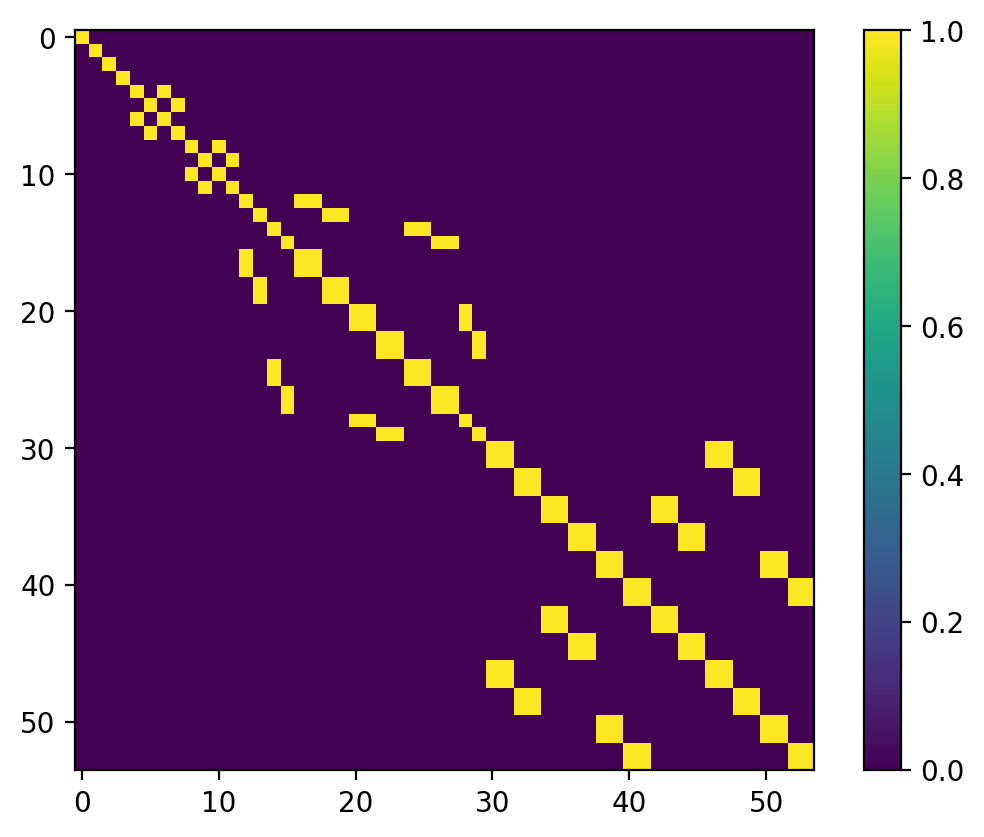

In [10]:
# There are redundant qets in that they only differ by a common phase.
rows = []
for total_ket_key_0, simple_ket_0 in simplified_kets.items():
    row = []
    for total_ket_key_1, simple_ket_1 in simplified_kets.items():
        the_sum = det_simplify((simple_ket_0 + simple_ket_1).dict)
        the_diff = det_simplify((simple_ket_0 - simple_ket_1).dict)
        if len(the_sum) == 0 or len(the_diff) == 0:
            row.append(1)
        else:
            row.append(0)
    rows.append(row)
plt.figure()
plt.imshow(np.array(rows))
plt.colorbar()
plt.show()

In [11]:
# This is alternative to qet division for figuring out
# which are proportional to each other
# supreme_qets = []
# corresponding_waves = []
# for total_ket_key_0, simple_ket_0 in simplified_kets.items():
#     plus_diffs = sum([len(det_simplify((simple_ket_0 + simple_ket_1).dict)) == 0 for simple_ket_1 in supreme_qets])
#     minus_diffs = sum([len(det_simplify((simple_ket_0 - simple_ket_1).dict)) == 0 for simple_ket_1 in supreme_qets])
#     if plus_diffs == 0 and minus_diffs == 0:
#         supreme_qets.append(simple_ket_0)
#         corresponding_waves.append(total_ket_key_0)

In [26]:
def qet_divide(qet0, qet1):
    '''
    Given   two   qets,   assumed   to   be   superpositions  of
    determinantal states. Determine if they are collinear and if
    they are, provide their ratio.

    Parameters
    ----------
    qet0    (qdef.Qet) : a qet with determinantal keys.
    qet1    (qdef.Qet) : a qet with determinantal keys.

    Returns
    -------
    ratio (num): 0 if qets are not collinear, otherwise equal to
    qet0/qet1.


    '''
    if len(qet0.dict) != len(qet1.dict):
        return 0
    set0 = frozenset(map(frozenset,qet0.dict.keys()))
    set1 = frozenset(map(frozenset,qet1.dict.keys()))
    num_parts = len(qet0.dict)
    # a necessary condition for them to be possibly collinear
    # is that they should have have the same sets of quantum
    # numbers.
    if set0 != set1:
        return 0
    else:
        ratios = []
        # iterate over the quantum nums of the first qet
        for qet_key_0, qet_val_0 in qet0.dict.items():
            set0 = set(qet_key_0)
            # and determine the ratio that it has
            # to all of the parts of the other qet
            # allowing for reaarangmenets valid
            # under determinantal state rules
            for qet_key_1, qet_val_1 in qet1.dict.items():
                set1 = set(qet_key_1)
                if set0 == set1:
                    ordering = [qet_key_0.index(qk) for qk in qet_key_1]
                    sign = εijk(*ordering)
                    ratios.append(sign * qet_val_0/qet_val_1)
                    continue
    if ratios == []:
        return 0
    else:
        # if all of the ratios are equal
        # then the ratio of the two qets
        # is well defined
        if len(set(ratios)) == 1 and len(ratios) == num_parts:
            return ratios[0]
        else:
            return 0

final_qets = []
corresponding_waves = []
for total_ket_key_0, simple_ket_0 in simplified_kets.items():
    ratios = []
    for simple_ket_1 in final_qets:
        divvy = qet_divide(simple_ket_0, simple_ket_1)
        ratios.append(divvy==0)
    ratios = sum(ratios)
    if ratios == len(final_qets):
        final_qets.append(simple_ket_0)
        corresponding_waves.append(total_ket_key_0)
final_qets = list(zip(corresponding_waves, final_qets))

In [27]:
import cmasher as cmr

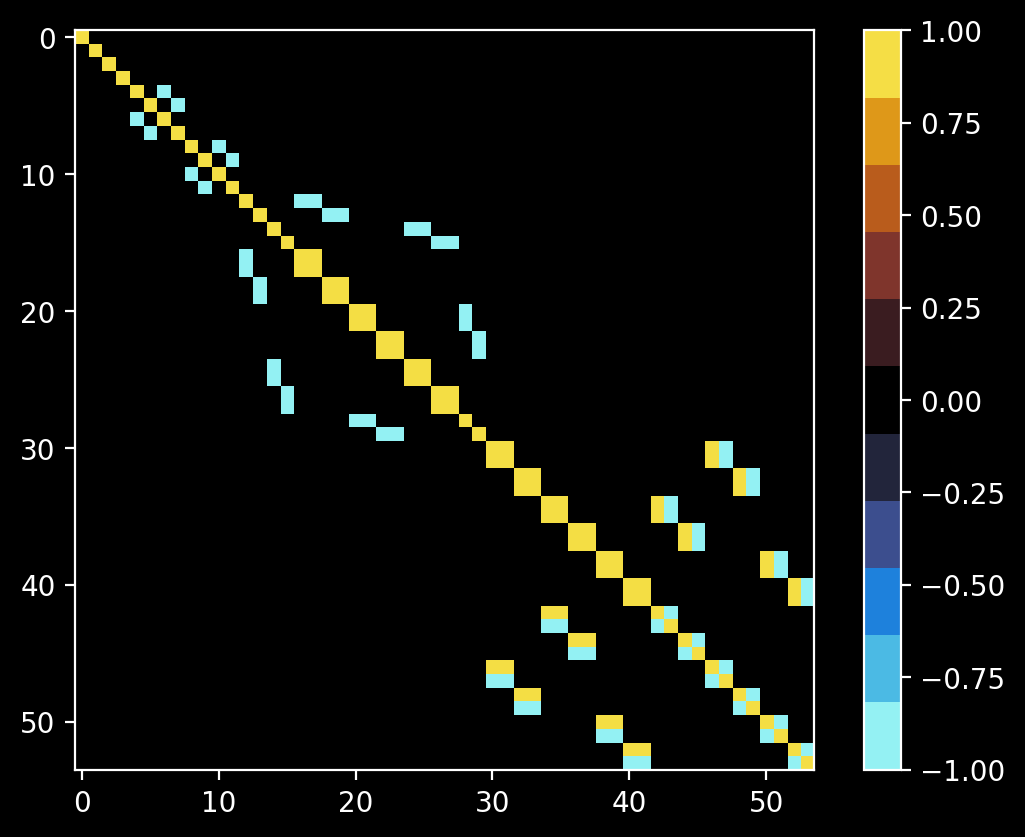

In [28]:
ratios = sp.Matrix([[qet_divide(q1, s0) for s0 in simplified_kets.values()] for q1 in simplified_kets.values()])
plt.style.use('dark_background')
plt.figure()
plt.imshow(np.array(ratios).astype(np.float64), cmap=cmr.get_sub_cmap('cmr.iceburn',0.,1,N=11))
plt.colorbar()
plt.show()

In [29]:
# in addition to removing the redundant ones
# I would also like to keep al the total_ket_keys that correspond to each
# group of redundant qets
final_qets_groups = {}
for main_key, sqet in final_qets:
    final_qets_groups[main_key] = {'paths':[],'qet':sqet}
    for total_ket_key_0, simple_ket_0 in simplified_kets.items():
        if qet_divide(sqet, simple_ket_0) != 0:
            final_qets_groups[main_key]['paths'].append(total_ket_key_0)
for k,v in final_qets_groups.items():
    print(k,'||', len(v['paths']), '||', (v['paths']))
    display(as_det_ket(v['qet']))

(A_2, {\beta}, 4, -3/2, 1, T_1) || 1 || [(A_2, {\beta}, 4, -3/2, 1, T_1)]


-|\bar{{\xi}} \bar{{\phi}} \bar{{\chi}}|

(A_2, {\beta}, 4, -1/2, 1, T_1) || 1 || [(A_2, {\beta}, 4, -1/2, 1, T_1)]


-sqrt(3)*|\bar{{\xi}} \bar{{\phi}} {\chi}|/3 - sqrt(3)*|\bar{{\xi}} {\phi} \bar{{\chi}}|/3 - sqrt(3)*|{\xi} \bar{{\phi}} \bar{{\chi}}|/3

(A_2, {\beta}, 4, 1/2, 1, T_1) || 1 || [(A_2, {\beta}, 4, 1/2, 1, T_1)]


-sqrt(3)*|\bar{{\xi}} {\phi} {\chi}|/3 - sqrt(3)*|{\xi} \bar{{\phi}} {\chi}|/3 - sqrt(3)*|{\xi} {\phi} \bar{{\chi}}|/3

(A_2, {\beta}, 4, 3/2, 1, T_1) || 1 || [(A_2, {\beta}, 4, 3/2, 1, T_1)]


-|{\xi} {\phi} {\chi}|

(E, {\gamma}, 2, -1/2, 1, T_1) || 2 || [(E, {\gamma}, 2, -1/2, 1, T_1), (E, {\gamma}, 2, -1/2, 0, T_2)]


-sqrt(2)*|\bar{{\xi}} \bar{{\phi}} {\chi}|/2 + sqrt(2)*|\bar{{\xi}} {\phi} \bar{{\chi}}|/2

(E, {\zeta}, 2, -1/2, 1, T_1) || 2 || [(E, {\zeta}, 2, -1/2, 1, T_1), (E, {\zeta}, 2, -1/2, 0, T_2)]


sqrt(6)*|\bar{{\xi}} \bar{{\phi}} {\chi}|/6 + sqrt(6)*|\bar{{\xi}} {\phi} \bar{{\chi}}|/6 - sqrt(6)*|{\xi} \bar{{\phi}} \bar{{\chi}}|/3

(E, {\gamma}, 2, 1/2, 1, T_1) || 2 || [(E, {\gamma}, 2, 1/2, 1, T_1), (E, {\gamma}, 2, 1/2, 0, T_2)]


-sqrt(2)*|{\xi} \bar{{\phi}} {\chi}|/2 + sqrt(2)*|{\xi} {\phi} \bar{{\chi}}|/2

(E, {\zeta}, 2, 1/2, 1, T_1) || 2 || [(E, {\zeta}, 2, 1/2, 1, T_1), (E, {\zeta}, 2, 1/2, 0, T_2)]


sqrt(6)*|\bar{{\xi}} {\phi} {\chi}|/3 - sqrt(6)*|{\xi} \bar{{\phi}} {\chi}|/6 - sqrt(6)*|{\xi} {\phi} \bar{{\chi}}|/6

(T_1, {\nu}, 2, -1/2, 0, E) || 3 || [(T_1, {\nu}, 2, -1/2, 0, E), (T_1, {\nu}, 2, -1/2, 1, T_1), (T_1, {\nu}, 2, -1/2, 0, T_2)]


-sqrt(2)*|\bar{{\chi}} {\chi} \bar{{\phi}}|/2 + sqrt(2)*|\bar{{\xi}} {\xi} \bar{{\phi}}|/2

(T_1, {\nu}, 2, 1/2, 0, E) || 3 || [(T_1, {\nu}, 2, 1/2, 0, E), (T_1, {\nu}, 2, 1/2, 1, T_1), (T_1, {\nu}, 2, 1/2, 0, T_2)]


-sqrt(2)*|\bar{{\chi}} {\chi} {\phi}|/2 + sqrt(2)*|\bar{{\xi}} {\xi} {\phi}|/2

(T_1, {\eta}, 2, -1/2, 0, E) || 3 || [(T_1, {\eta}, 2, -1/2, 0, E), (T_1, {\eta}, 2, -1/2, 1, T_1), (T_1, {\eta}, 2, -1/2, 0, T_2)]


sqrt(2)*|\bar{{\phi}} {\phi} \bar{{\chi}}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} \bar{{\chi}}|/2

(T_1, {\eta}, 2, 1/2, 0, E) || 3 || [(T_1, {\eta}, 2, 1/2, 0, E), (T_1, {\eta}, 2, 1/2, 1, T_1), (T_1, {\eta}, 2, 1/2, 0, T_2)]


sqrt(2)*|\bar{{\phi}} {\phi} {\chi}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} {\chi}|/2

(T_1, {\mu}, 2, -1/2, 1, T_1) || 3 || [(T_1, {\mu}, 2, -1/2, 1, T_1), (T_1, {\mu}, 2, -1/2, 0, T_2), (T_1, {\mu}, 2, -1/2, 0, E)]


-sqrt(2)*|\bar{{\xi}} \bar{{\chi}} {\chi}|/2 + sqrt(2)*|\bar{{\xi}} \bar{{\phi}} {\phi}|/2

(T_1, {\mu}, 2, 1/2, 1, T_1) || 3 || [(T_1, {\mu}, 2, 1/2, 1, T_1), (T_1, {\mu}, 2, 1/2, 0, T_2), (T_1, {\mu}, 2, 1/2, 0, E)]


-sqrt(2)*|{\xi} \bar{{\chi}} {\chi}|/2 + sqrt(2)*|{\xi} \bar{{\phi}} {\phi}|/2

(T_2, {\xi}, 2, -1/2, 0, A_1) || 4 || [(T_2, {\xi}, 2, -1/2, 0, A_1), (T_2, {\xi}, 2, -1/2, 0, E), (T_2, {\xi}, 2, -1/2, 1, T_1), (T_2, {\xi}, 2, -1/2, 0, T_2)]


-sqrt(2)*|\bar{{\chi}} {\chi} \bar{{\xi}}|/2 - sqrt(2)*|\bar{{\phi}} {\phi} \bar{{\xi}}|/2

(T_2, {\xi}, 2, 1/2, 0, A_1) || 4 || [(T_2, {\xi}, 2, 1/2, 0, A_1), (T_2, {\xi}, 2, 1/2, 0, E), (T_2, {\xi}, 2, 1/2, 1, T_1), (T_2, {\xi}, 2, 1/2, 0, T_2)]


-sqrt(2)*|\bar{{\chi}} {\chi} {\xi}|/2 - sqrt(2)*|\bar{{\phi}} {\phi} {\xi}|/2

(T_2, {\phi}, 2, -1/2, 0, A_1) || 4 || [(T_2, {\phi}, 2, -1/2, 0, A_1), (T_2, {\phi}, 2, -1/2, 0, E), (T_2, {\phi}, 2, -1/2, 1, T_1), (T_2, {\phi}, 2, -1/2, 0, T_2)]


-sqrt(2)*|\bar{{\chi}} {\chi} \bar{{\phi}}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} \bar{{\phi}}|/2

(T_2, {\phi}, 2, 1/2, 0, A_1) || 4 || [(T_2, {\phi}, 2, 1/2, 0, A_1), (T_2, {\phi}, 2, 1/2, 0, E), (T_2, {\phi}, 2, 1/2, 1, T_1), (T_2, {\phi}, 2, 1/2, 0, T_2)]


-sqrt(2)*|\bar{{\chi}} {\chi} {\phi}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} {\phi}|/2

(T_2, {\chi}, 2, -1/2, 0, A_1) || 4 || [(T_2, {\chi}, 2, -1/2, 0, A_1), (T_2, {\chi}, 2, -1/2, 0, E), (T_2, {\chi}, 2, -1/2, 1, T_1), (T_2, {\chi}, 2, -1/2, 0, T_2)]


-sqrt(2)*|\bar{{\phi}} {\phi} \bar{{\chi}}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} \bar{{\chi}}|/2

(T_2, {\chi}, 2, 1/2, 0, A_1) || 4 || [(T_2, {\chi}, 2, 1/2, 0, A_1), (T_2, {\chi}, 2, 1/2, 0, E), (T_2, {\chi}, 2, 1/2, 1, T_1), (T_2, {\chi}, 2, 1/2, 0, T_2)]


-sqrt(2)*|\bar{{\phi}} {\phi} {\chi}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} {\chi}|/2

In [55]:
display(Math('$%s$' % sp.latex(as_det_ket(sq))))

<IPython.core.display.Math object>

In [47]:
for idx, sq in enumerate(supreme_qets):
    total_ket_key = (corresponding_waves[idx])
    e_config = sp.Symbol(sp.latex(Γ1).lower())*sp.Symbol(sp.latex(Γ2).lower())*sp.Symbol(sp.latex(Γ3).lower())
    final_term_symbol = sp.Symbol('{}^{%d}%s' % (total_ket_key[2],sp.latex(total_ket_key[0])))
    intermediate_term_symbol = sp.Symbol('{}^{%d}%s' % (int(total_ket_key[-2]*2+1),sp.latex(total_ket_key[-1])))
    three_qet_symb = sp.Matrix([e_config, sp.Symbol('(%s)' % sp.latex(intermediate_term_symbol)),final_term_symbol, total_ket_key[3], total_ket_key[1]]).T
    display(three_qet_symb)
    display(as_det_ket(sq))

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{4}A_{2}, -3/2, {\beta}]])

-|\bar{{\xi}} \bar{{\phi}} \bar{{\chi}}|

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{4}A_{2}, -1/2, {\beta}]])

-sqrt(3)*|\bar{{\xi}} \bar{{\phi}} {\chi}|/3 - sqrt(3)*|\bar{{\xi}} {\phi} \bar{{\chi}}|/3 - sqrt(3)*|{\xi} \bar{{\phi}} \bar{{\chi}}|/3

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{4}A_{2}, 1/2, {\beta}]])

-sqrt(3)*|\bar{{\xi}} {\phi} {\chi}|/3 - sqrt(3)*|{\xi} \bar{{\phi}} {\chi}|/3 - sqrt(3)*|{\xi} {\phi} \bar{{\chi}}|/3

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{4}A_{2}, 3/2, {\beta}]])

-|{\xi} {\phi} {\chi}|

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{2}E, -1/2, {\gamma}]])

-sqrt(2)*|\bar{{\xi}} \bar{{\phi}} {\chi}|/2 + sqrt(2)*|\bar{{\xi}} {\phi} \bar{{\chi}}|/2

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{2}E, -1/2, {\zeta}]])

sqrt(6)*|\bar{{\xi}} \bar{{\phi}} {\chi}|/6 + sqrt(6)*|\bar{{\xi}} {\phi} \bar{{\chi}}|/6 - sqrt(6)*|{\xi} \bar{{\phi}} \bar{{\chi}}|/3

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{2}E, 1/2, {\gamma}]])

-sqrt(2)*|{\xi} \bar{{\phi}} {\chi}|/2 + sqrt(2)*|{\xi} {\phi} \bar{{\chi}}|/2

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{2}E, 1/2, {\zeta}]])

sqrt(6)*|\bar{{\xi}} {\phi} {\chi}|/3 - sqrt(6)*|{\xi} \bar{{\phi}} {\chi}|/6 - sqrt(6)*|{\xi} {\phi} \bar{{\chi}}|/6

Matrix([[t_{2}**3, ({}^{1}E), {}^{2}T_{1}, -1/2, {\nu}]])

-sqrt(2)*|\bar{{\chi}} {\chi} \bar{{\phi}}|/2 + sqrt(2)*|\bar{{\xi}} {\xi} \bar{{\phi}}|/2

Matrix([[t_{2}**3, ({}^{1}E), {}^{2}T_{1}, 1/2, {\nu}]])

-sqrt(2)*|\bar{{\chi}} {\chi} {\phi}|/2 + sqrt(2)*|\bar{{\xi}} {\xi} {\phi}|/2

Matrix([[t_{2}**3, ({}^{1}E), {}^{2}T_{1}, -1/2, {\eta}]])

sqrt(2)*|\bar{{\phi}} {\phi} \bar{{\chi}}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} \bar{{\chi}}|/2

Matrix([[t_{2}**3, ({}^{1}E), {}^{2}T_{1}, 1/2, {\eta}]])

sqrt(2)*|\bar{{\phi}} {\phi} {\chi}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} {\chi}|/2

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{2}T_{1}, -1/2, {\mu}]])

-sqrt(2)*|\bar{{\xi}} \bar{{\chi}} {\chi}|/2 + sqrt(2)*|\bar{{\xi}} \bar{{\phi}} {\phi}|/2

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{2}T_{1}, 1/2, {\mu}]])

-sqrt(2)*|{\xi} \bar{{\chi}} {\chi}|/2 + sqrt(2)*|{\xi} \bar{{\phi}} {\phi}|/2

Matrix([[t_{2}**3, ({}^{1}A_{1}), {}^{2}T_{2}, -1/2, {\xi}]])

-sqrt(2)*|\bar{{\chi}} {\chi} \bar{{\xi}}|/2 - sqrt(2)*|\bar{{\phi}} {\phi} \bar{{\xi}}|/2

Matrix([[t_{2}**3, ({}^{1}A_{1}), {}^{2}T_{2}, 1/2, {\xi}]])

-sqrt(2)*|\bar{{\chi}} {\chi} {\xi}|/2 - sqrt(2)*|\bar{{\phi}} {\phi} {\xi}|/2

Matrix([[t_{2}**3, ({}^{1}A_{1}), {}^{2}T_{2}, -1/2, {\phi}]])

-sqrt(2)*|\bar{{\chi}} {\chi} \bar{{\phi}}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} \bar{{\phi}}|/2

Matrix([[t_{2}**3, ({}^{1}A_{1}), {}^{2}T_{2}, 1/2, {\phi}]])

-sqrt(2)*|\bar{{\chi}} {\chi} {\phi}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} {\phi}|/2

Matrix([[t_{2}**3, ({}^{1}A_{1}), {}^{2}T_{2}, -1/2, {\chi}]])

-sqrt(2)*|\bar{{\phi}} {\phi} \bar{{\chi}}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} \bar{{\chi}}|/2

Matrix([[t_{2}**3, ({}^{1}A_{1}), {}^{2}T_{2}, 1/2, {\chi}]])

-sqrt(2)*|\bar{{\phi}} {\phi} {\chi}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} {\chi}|/2

In [130]:
# bar symbols according to their spin
def slater_det(single_electron_state):
    spinors = []
    for ses in single_electron_state:
        if ses[0] < 0:
            spinor = sp.Symbol(r'\bar{%s}' % sp.latex(ses[1]))
        else:
            spinor = ses[1]
        spinors.append(spinor)
    # qet_dict = [((spinor[0],spinor[1],spinor[2]),1),
    #             (spinor[])]
    apply_permutation = lambda σ, iter : (iter[σ[0]], iter[σ[1]], iter[σ[2]])
    # find the permutations
    σs = list(permutations(range(len(spinors)), len(spinors)))
    # apply with their corresponding sign
    slater  = ([(apply_permutation(σ, spinors), εijk(*σ)) for σ in σs])
    qet = Qet()
    for slate in slater:
        qet += Qet({slate[0]:slate[1]})
    return qet

Qet({(\bar{{\xi}}, {\chi}, {\xi}): -sqrt(2)/2, (\bar{{\phi}}, {\chi}, {\phi}): -sqrt(2)/2})

In [ ]:
total_kets_symmetrized = {}
for total_ket_key, ket_parts in simplified_kets.items():
    slater_parts = [slater_det(k)*v for k,v in ket_parts.dict.items()]
    total_sym = sum(slater_parts, Qet({}))
    if len(total_sym.dict) > 0:
        total_kets_symmetrized[total_ket_key] = total_sym